In [1]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 1000 # 20


# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  20 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('z-')
target_derivative = op.spin_dm('z+')

# -- initial parameter guess --
z0= np.ones(num_steps)*0.0
x0 = np.ones(num_steps) * 2.0 # * (np.pi) / (dt*num_steps)




parameter_list=[item for pair in zip(x0, z0) for item in pair] # this makes a list without the inner tuples


In [2]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0% 1000 of 1000 [########################################] 00:02:03
Elapsed time: 123.7s


In [4]:
def hamiltonian(hx,hz):

    hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
    hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

    return hz_sz + hx_sx

parameterized_system=oqupy.ParameterizedSystem(hamiltonian)



In [4]:
reshapedparas=[i for i in (np.array(parameter_list).reshape((-1,2))).tolist() for j in range(2)]
dynamics=oqupy.state_gradient(system=parameterized_system,initial_state=initial_state,
                     target_derivative=target_derivative,process_tensors=[process_tensor],dynamics_only=True,
                     parameters=reshapedparas)['dynamics']

--> Compute dynamics:
100.0% 1000 of 1000 [########################################] 00:00:13
Elapsed time: 13.6s


In [7]:
reshapedparas=[i for i in (np.array(parameter_list).reshape((-1,2))).tolist() for j in range(2)]

In [4]:
reshapedparas=[i for i in (np.array(parameter_list).reshape((-1,2))).tolist() for j in range(2)]

dynamics=oqupy.state_gradient(system=parameterized_system,initial_state=initial_state,
                     target_derivative=target_derivative,process_tensors=[process_tensor],dynamics_only=True,
                     parameters=reshapedparas)['dynamics']

--> Compute dynamics:
100.0% 1000 of 1000 [########################################] 00:00:03
Elapsed time: 3.3s


In [7]:
np.max(process_tensor.get_bond_dimensions())

40

In [9]:
%prun dynamics=oqupy.state_gradient(system=parameterized_system,initial_state=initial_state,target_derivative=target_derivative,process_tensors=[process_tensor],dynamics_only=True,parameters=reshapedparas)['dynamics']

--> Compute dynamics:
100.0% 1000 of 1000 [########################################] 00:00:20
Elapsed time: 20.0s
 

         40228945 function calls (40228943 primitive calls) in 20.076 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    9.363    0.009   16.210    0.016 util.py:32(create_delta)
 27392280    3.381    0.000    3.381    0.000 util.py:49(<genexpr>)
  5479456    2.330    0.000    3.293    0.000 index_tricks.py:690(__next__)
  5511456    0.967    0.000    0.967    0.000 {built-in method builtins.next}
    13042    0.649    0.000    0.649    0.000 {method 'acquire' of '_thread.lock' objects}
     2000    0.463    0.000    0.568    0.000 _matfuncs.py:216(expm)
    35005    0.367    0.000    0.367    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     4001    0.307    0.000    0.773    0.000 numeric.py:932(tensordot)
     9002    0.119    0.000    0.119    0.000 {built-in method numpy.zeros}
    14003    0.114    0.000    0.114    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     4000    0.102    0.000    0.278 

In [8]:
%prun dynamics=oqupy.state_gradient(system=parameterized_system,initial_state=initial_state,target_derivative=target_derivative,process_tensors=[process_tensor],dynamics_only=True,parameters=reshapedparas)['dynamics']

--> Compute dynamics:
100.0% 1000 of 1000 [########################################] 00:00:03
Elapsed time: 3.9s
 

         1858835 function calls (1858833 primitive calls) in 3.929 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    13042    0.569    0.000    0.569    0.000 {method 'acquire' of '_thread.lock' objects}
     2000    0.433    0.000    0.533    0.000 _matfuncs.py:216(expm)
     1000    0.381    0.000    0.492    0.000 util.py:51(create_delta_noscramble)
    35005    0.314    0.000    0.314    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     4001    0.184    0.000    0.542    0.000 numeric.py:932(tensordot)
     7002    0.118    0.000    0.118    0.000 {built-in method numpy.zeros}
    14003    0.103    0.000    0.103    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     4000    0.098    0.000    0.272    0.000 shape_base.py:1067(kron)
    42010    0.088    0.000    0.172    0.000 network_components.py:146(add_edge)
     3012    0.073    0.000    0.073    0.000 socket.py:621(send)
    10004    0.060    0.000    0

In [6]:
tensor=process_tensor._mpo_tensors[5]
withdelta=oqupy.util.create_delta(tensor,[0,1,2,2])
withdelta2=oqupy.util.create_delta_noscramble(tensor)

3


In [14]:
np.all(withdelta-withdelta2==0)

True

In [20]:
tensor.shape+(tensor.shape[-1],)

(21, 22, 4, 4)

In [15]:
(tensor.shape[:],tensor.shape[-1])

((21, 22, 4), 4)

/Users/paul/OQuPy/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/paul/OQuPy/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


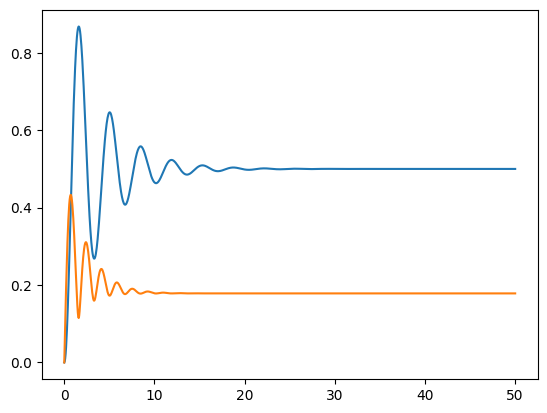

In [5]:
t,sz=dynamics.expectations(oqupy.operators.sigma('z')/2)
t,sx=dynamics.expectations(oqupy.operators.sigma('x')/2)
t,sy=dynamics.expectations(oqupy.operators.sigma('y')/2)
plt.plot(t,sz+0.5)
plt.plot(t,np.sqrt(sx**2+sy**2))
#plt.plot(t,sy)
#plt.plot(t,sy)

In [7]:
params = {
   'axes.labelsize': 10,
   'font.size': 10,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 3.2]
   }
plt.rcParams.update(params)

In [8]:
import matplotlib.patches as mpatch

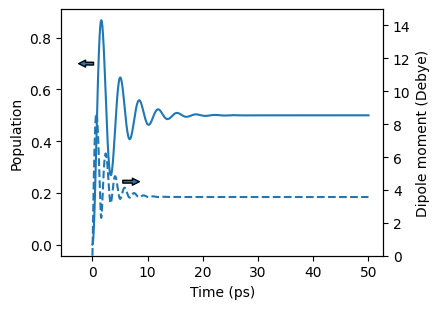

In [9]:
fig,ax1=plt.subplots()
ax1.plot(t,sz+0.5)
ax1.set_xlabel('Time (ps)')
ax1.set_ylabel('Population')
ax1.add_patch(mpatch.FancyArrowPatch((0.7,0.7),(-3.0,0.7),mutation_scale=10))
ax2=ax1.twinx()
ax2.plot(t,20*np.sqrt(sx**2+sy**2),linestyle='dashed')
ax2.set_ylabel('Dipole moment (Debye)')
ax2.set_ylim(0,15)
ax2.add_patch(mpatch.FancyArrowPatch((5,4.5),(9,4.5),mutation_scale=10))
fig.tight_layout()

In [10]:
fig.savefig('example_excitondynamics.png')

/home/easthamp/OQuPy/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/easthamp/OQuPy/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


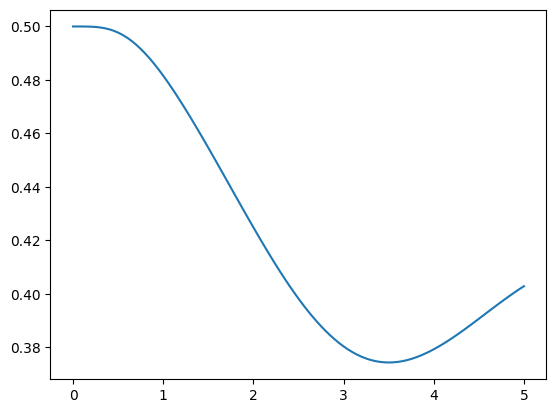

In [ ]:
plt.plot(t,np.sqrt(sx**2+sy**2+sz**2))

In [ ]:
def infidandgrad(paras):
    # take a numpy array hx0, hz0, hx1, hz1, ... over full timesteps
    # return the fidelity and gradient of the fidelity to the global target_derivative
    reshapedparas=[i for i in (paras.reshape((-1,2))).tolist() for j in range(2)]
    eoinscode=oqupy.state_gradient(system=parameterized_system,
        initial_state=initial_state,
        target_derivative=target_derivative.T,
        process_tensors=[process_tensor],
        parameters=reshapedparas)
    fs=eoinscode['final state']
    gps=eoinscode['gradient']
    fidelity=np.sum(fs*target_derivative.T)
    for i in range(0,gps.shape[0],2): 
        gps[i,:]=gps[i,:]+gps[i+1,:]
    gps=gps[0::2]
    return 1-fidelity.real,(-1.0*gps.reshape((-1)).real).tolist()

In [ ]:
infid,grad=infidandgrad(np.array(parameter_list))

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s


In [ ]:
lbx=[-5*np.pi for i in range(num_steps)]
lbz=[-np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ubx=[5*np.pi for i in range(num_steps)]
ubz=[np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ub_list=[item for pair in zip(ubx, ubz) for item in pair]

In [ ]:
from scipy.optimize import minimize,Bounds

optimization_result = minimize(
                        fun=infidandgrad,
                        x0=np.array(parameter_list),
                        method='L-BFGS-B',
                        jac=True,
                        bounds=Bounds(lb_list,ub_list),
                        options = {'disp':True,'gtol': 7e-05})

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
El

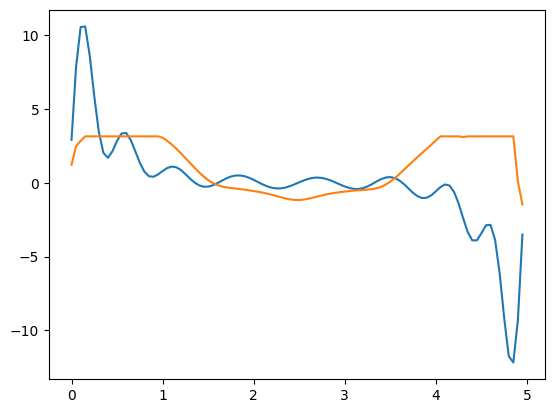

In [ ]:
times=dt*np.arange(num_steps)
plt.plot(times,optimization_result['x'][0::2])
plt.plot(times,optimization_result['x'][1::2])